### Spaceship Titanic은 titanic과 비슷한 상황이 1000년 이후에 벌어진 것을 말합니다. 이진 분류 모델을 XGBoost를 사용하여 모델링을 해보세요.

- 데이터 링크 : https://drive.google.com/drive/folders/1UTft-BlveN5AUN5vMd2yoN4xzvvHRC5D?usp=drive_link

- 데이터 설명 : https://www.kaggle.com/competitions/spaceship-titanic/data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## 1. 라이브러리, 데이터 불러오기

In [5]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark", context="notebook")

import os
import random

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

In [153]:
# 데이터를 불러옵니다.
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

### 데이터 상세
- `PassengerId`
    - 형태 **gggg_pp**
    - **gggg** 는 여행 중인 승객 그룹을 의미하며, 가족이 속해있을 수 있다.
    - **pp** 개별 번호
- `HomePlanet`
    - 출발 행성
- `CryoSleep`
    - 냉동 수면 상태를 나타냄.
    - 냉동 수면 상태의 승객들은 cabin 에 있다.
- `Cabin`
    - 승객이 머무르는 cabin 의 번호
    - **deck/num/side** 의 형태
    - **side** 는 P or S
- `Destination`
    - 승객이 하차하는 행성
- `Age`
    - 승객의 나이
- `VIP`
    - 항해 동안 승객이 VIP 서비스를 지불했는지를 나타냄
- `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck`
    - luxury amenities 에 지불한 정도
- `Name`
- `Transported`
    - Target (다른 행성으로 이동되었는가)

## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- 데이터 설명을 자세히 읽고, feature engineering에 필요한 여러가지 특징들을 찾아봅시다.

In [154]:
## 1. 결측치 체크  --> 특정 column이 많은 결측치를 포함하고 있는지!
# -> 'PassengerId' 와 'Transported' 를 제외한 모든 columns 가 결측치를 포함함
train.info()
## 2. dtype이 object인 column들 체크 (str)
# -> 'PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name'
print('------------------Object Columns--------------------')
print(train.columns[train.dtypes == 'object'])
## 3. target value 정보를 체크 -----> class imbalance 체크! (이진분류) 10:1 이상인 경우
# -> 약 5:5 
print('---------------Target Imbalance Check---------------')
train.Transported.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
------------------Object Columns--------------------
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'N

Transported
True     4378
False    4315
Name: count, dtype: int64

In [155]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Numerical -> Categorical
- 앞서 Cabin 의 number, Amenities, Age 등 숫자와 관련된 데이터를 모두 삭제했더니 성능이 너무 떨어지는 현상이 생김
- Name 처럼 처리하기 힘든 것도 전부 삭제해버림

#### Numerical Values
- `Age`
- `Cabin_Num`
- `Amenities`

##### Age

In [156]:
# Age 결측치 처리
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(train['Age'].median())

<Axes: xlabel='Age', ylabel='Count'>

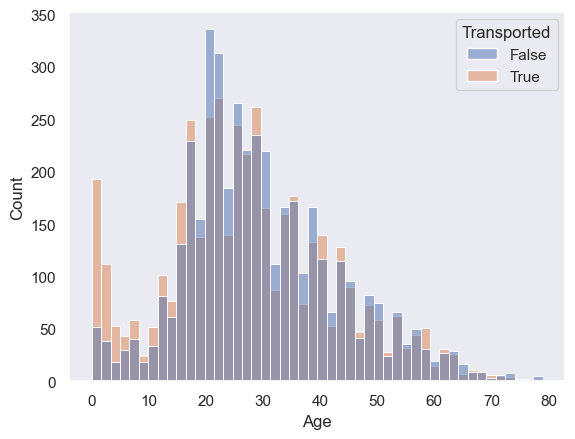

In [157]:
sns.histplot(train, x='Age', hue='Transported')

- `0~18` : **True < False** -> 0
- `19~34` : **False > True** -> 1
- `35~`: 비슷함 -> 2

In [158]:
# Age 처리
train['Age_Category'] = np.nan
train.loc[train['Age'] <= 18, 'Age_Category'] = 0
train.loc[(18 < train['Age']) & (train['Age'] <= 34), 'Age_Category'] = 1
train.loc[34 < train['Age'], 'Age_Category'] = 2

train['Age_Category'] = np.nan
train.loc[train['Age'] <= 18, 'Age_Category'] = 0
train.loc[(18 < train['Age']) & (train['Age'] <= 34), 'Age_Category'] = 1
train.loc[34 < train['Age'], 'Age_Category'] = 2

train.drop(columns='Age', inplace=True)
test.drop(columns='Age', inplace=True)

[Text(0, 0, '0.0'), Text(1, 0, '1.0'), Text(2, 0, '2.0')]

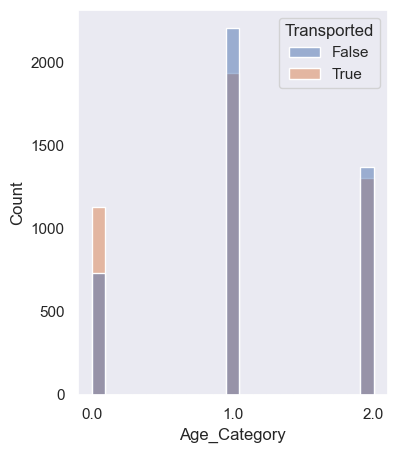

In [159]:
plt.figure(figsize=(4, 5))
ax = sns.histplot(data=train, x='Age_Category', hue='Transported')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['0.0', '1.0', '2.0'])

- `0`: True 강세
- `1`: False 강세
- `2`: 비슷

##### Amenities

<Axes: xlabel='VRDeck', ylabel='Count'>

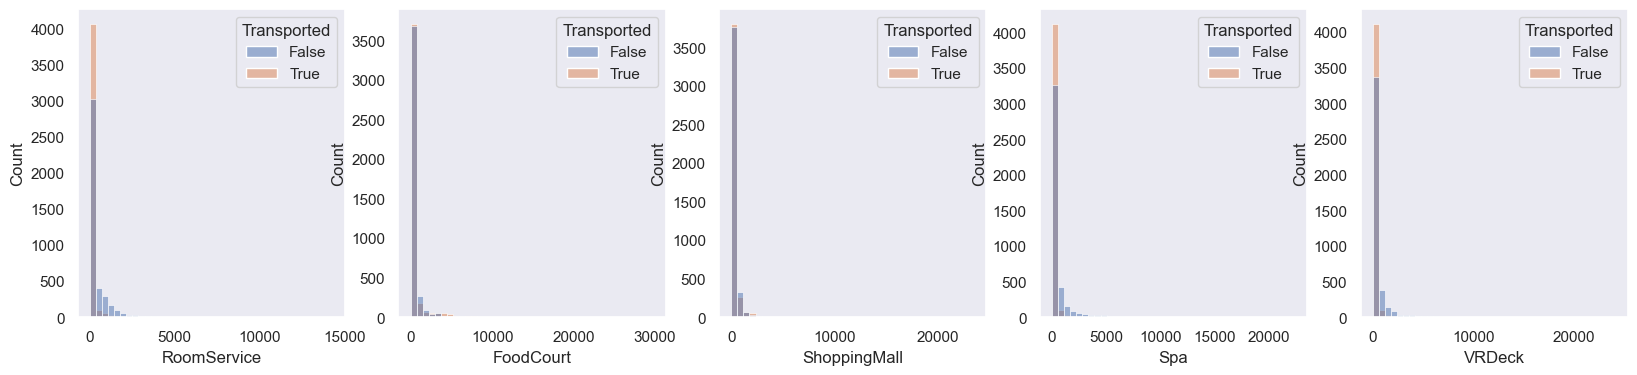

In [160]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))
sns.histplot(train, x='RoomService', hue='Transported', ax=ax1, bins=40)
sns.histplot(train, x='FoodCourt', hue='Transported', ax=ax2, bins=40)
sns.histplot(train, x='ShoppingMall', hue='Transported', ax=ax3, bins=40)
sns.histplot(train, x='Spa', hue='Transported', ax=ax4, bins=40)
sns.histplot(train, x='VRDeck', hue='Transported', ax=ax5, bins=40)
    

- 0 이 너무 많다. $\rightarrow$ Nan 값은 0으로 채우고, 아무런 지출을 안한 경우인 `Free` column 추가
- 15000 ~ 30000도 넘는 이상값이 존재함 $\rightarrow$ log ?

In [161]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
### NaN -> 0.0
train[amenities] = train[amenities].fillna(value=0.0)
test[amenities] = test[amenities].fillna(value=0.0)

### Free column
train['Total_Amenities'] = train[amenities].sum(axis=1)
train['Free'] = train['Total_Amenities'].apply(lambda x: 1 if not x else 0)
test['Total_Amenities'] = test[amenities].sum(axis=1)
test['Free'] = test['Total_Amenities'].apply(lambda x: 1 if not x else 0)

<Axes: xlabel='Total_Amenities', ylabel='Count'>

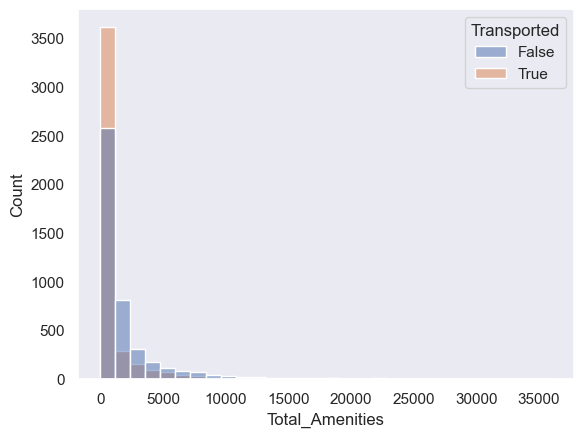

In [162]:
sns.histplot(train, x='Total_Amenities', hue='Transported',bins=30)

$\rightarrow$ 지출이 0인것과 아닌 것의 Transported 형성에 차이가 있다.

[Text(0, 0, '0'), Text(1, 0, '1')]

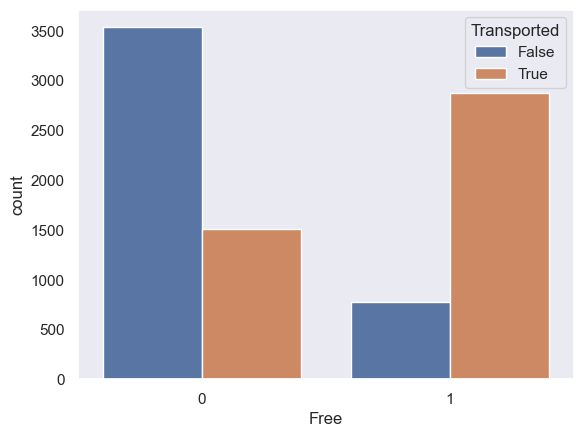

In [163]:

ax = sns.countplot(data=train, x='Free', hue='Transported')
ax.set_xticks([0, 1])
ax.set_xticklabels(['0', '1'])


##### Cabin

In [164]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_Category,Total_Amenities,Free
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,2.0,0.0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1.0,736.0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,2.0,10383.0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1.0,5176.0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0.0,1091.0,0


In [165]:
# NaN 때문에 Split 이 안됨.
train['Cabin'] = train['Cabin'].fillna('NaN/NaN/NaN')
test['Cabin'] = test['Cabin'].fillna('NaN/NaN/NaN')

train[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = train['Cabin'].str.split('/', expand=True)
train.replace({'Cabin_deck': 'NaN', 'Cabin_num': 'NaN', 'Cabin_side': 'NaN'}, np.nan, inplace=True)
train['Cabin_num'] = train['Cabin_num'].fillna(10000)
train['Cabin_num'] = train['Cabin_num'].astype(int)
train['Cabin_num'].replace(10000, np.nan, inplace=True)

test[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = test['Cabin'].str.split('/', expand=True)
test.replace({'Cabin_deck': 'NaN', 'Cabin_num': 'NaN', 'Cabin_side': 'NaN'}, np.nan, inplace=True)
test['Cabin_num'] = test['Cabin_num'].fillna(10000)
test['Cabin_num'] = test['Cabin_num'].astype(int)
test['Cabin_num'].replace(10000, np.nan, inplace=True)

train.drop(columns='Cabin', inplace=True)
test.drop(columns='Cabin', inplace=True)

`Cabin_deck`

<Axes: xlabel='Cabin_deck', ylabel='Count'>

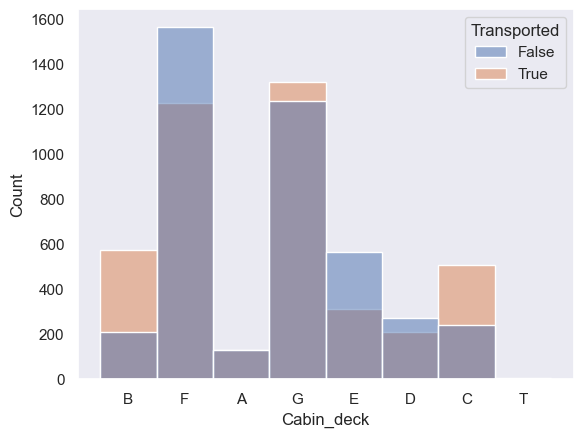

In [166]:
sns.histplot(train, x='Cabin_deck', hue='Transported')

무슨관계일까 ?
- **A, B, C, G**
- **D, E, F**

`Cabin_num`

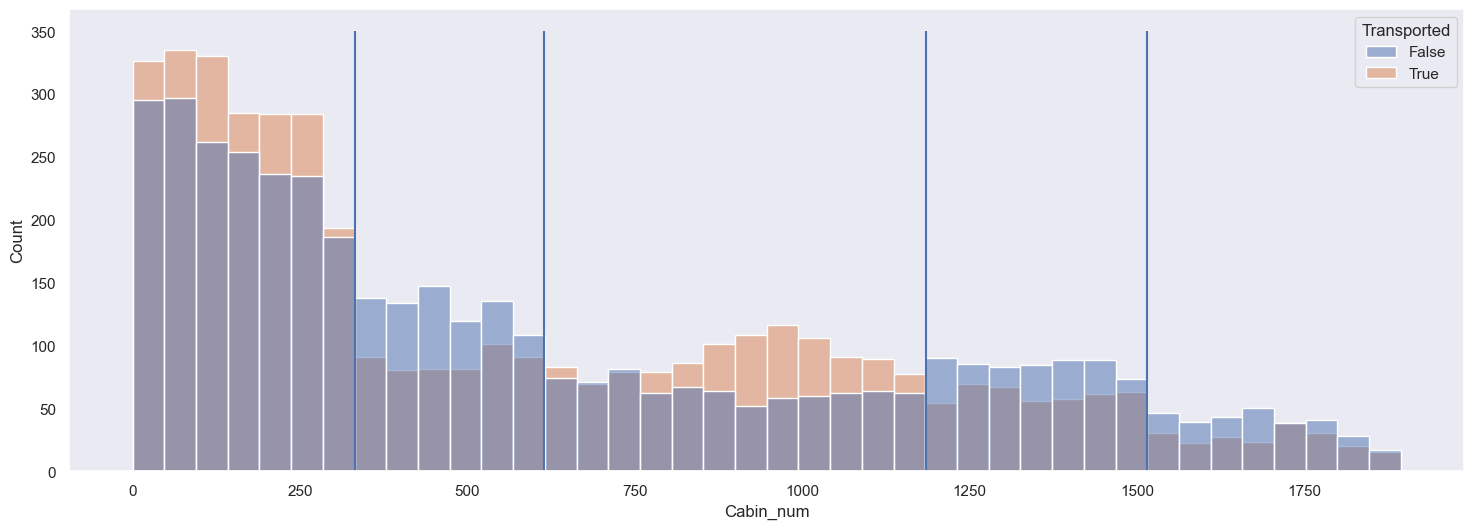

In [167]:
plt.figure(figsize=(18, 6))
sns.histplot(train, x='Cabin_num', hue='Transported', bins=40)
plt.vlines(332, 0, 350)
plt.vlines(615, 0, 350)
plt.vlines(1185, 0, 350)
plt.vlines(1515, 0, 350)

In [168]:
# Cabin_num 처리
train['Cabin_num_category'] = np.nan
train.loc[train['Cabin_num'] <= 332, 'Cabin_num_category'] = 0
train.loc[(332 < train['Cabin_num']) & (train['Cabin_num'] <= 615), 'Cabin_num_category'] = 1
train.loc[(615 < train['Cabin_num']) & (train['Cabin_num'] <= 1185), 'Cabin_num_category'] = 2
train.loc[(1185 < train['Cabin_num']) & (train['Cabin_num'] <= 1515), 'Cabin_num_category'] = 3
train.loc[1515 < train['Cabin_num'], 'Cabin_num_category'] = 4

test['Cabin_num_category'] = np.nan
test.loc[test['Cabin_num'] <= 332, 'Cabin_num_category'] = 0
test.loc[(332 < test['Cabin_num']) & (test['Cabin_num'] <= 615), 'Cabin_num_category'] = 1
test.loc[(615 < test['Cabin_num']) & (test['Cabin_num'] <= 1185), 'Cabin_num_category'] = 2
test.loc[(1185 < test['Cabin_num']) & (test['Cabin_num'] <= 1515), 'Cabin_num_category'] = 3
test.loc[1515 < test['Cabin_num'], 'Cabin_num_category'] = 4

train.drop(columns='Cabin_num', inplace=True)
test.drop(columns='Cabin_num', inplace=True)

<Axes: xlabel='Cabin_side', ylabel='Count'>

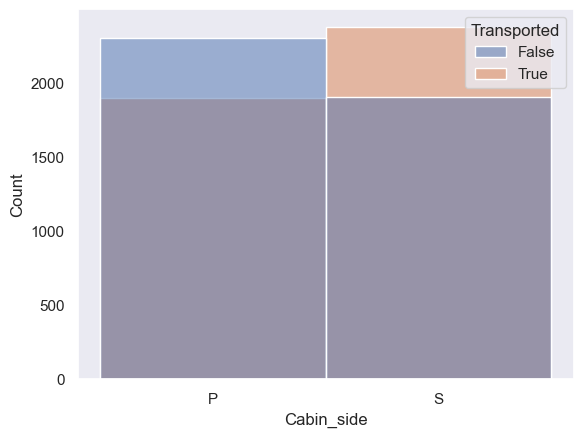

In [169]:
sns.histplot(train, x='Cabin_side', hue='Transported')

#### Numerical 끝

In [170]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         8693 non-null   object 
 1   HomePlanet          8492 non-null   object 
 2   CryoSleep           8476 non-null   object 
 3   Destination         8511 non-null   object 
 4   VIP                 8490 non-null   object 
 5   RoomService         8693 non-null   float64
 6   FoodCourt           8693 non-null   float64
 7   ShoppingMall        8693 non-null   float64
 8   Spa                 8693 non-null   float64
 9   VRDeck              8693 non-null   float64
 10  Name                8493 non-null   object 
 11  Transported         8693 non-null   bool   
 12  Age_Category        8693 non-null   float64
 13  Total_Amenities     8693 non-null   float64
 14  Free                8693 non-null   int64  
 15  Cabin_deck          8494 non-null   object 
 16  Cabin_

- `HomePlanet`
- `CryoSleep`
- `Destination`
- `VIP`
- `Name` -> 버리자
- `Cabin`s

`Name`

In [171]:
train.drop(columns='Name', inplace=True)
test.drop(columns='Name', inplace=True)

`VIP`

In [172]:
train.VIP.value_counts()

VIP
False    8291
True      199
Name: count, dtype: int64

In [173]:
train.VIP.fillna(False, inplace=True)
test.VIP.fillna(False, inplace=True)

`CryoSleep`
- 자는데 VIP 일 필요 없다.
- 자는데 돈 쓸일 없다.

<Axes: xlabel='CryoSleep', ylabel='Free'>

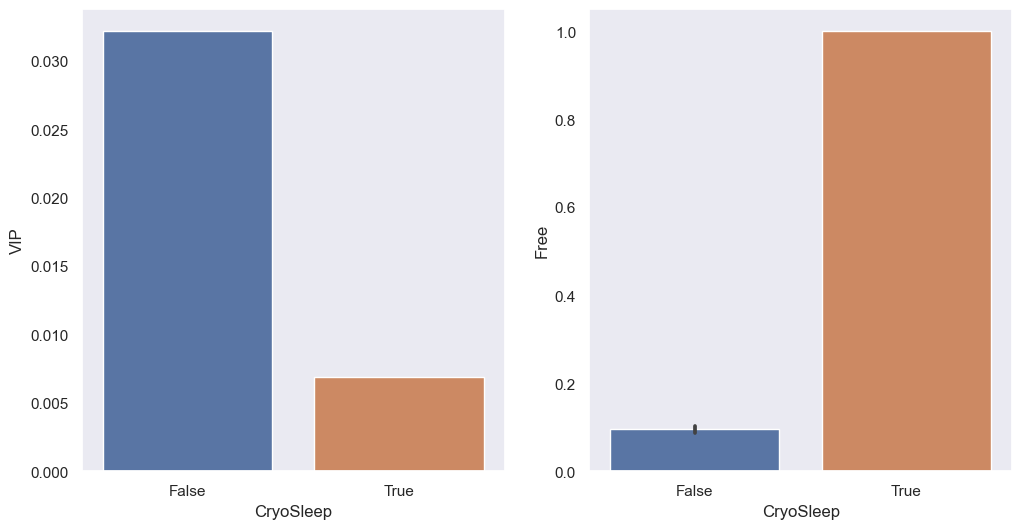

In [178]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6))
sns.barplot(train, x='CryoSleep', y='VIP', errorbar=None, ax=ax1)
sns.barplot(train, x='CryoSleep', y='Free', ax=ax2)

In [179]:
def fill_cryopsleep(row):
    if pd.notnull(row['CryoSleep']):
        return row
    # Amenities  아예 0원
    if row['Free']:
        row['CryoSleep'] = True
    elif pd.isnull(row['CryoSleep']) and not row['Free']:
        row['CryoSleep'] = False
    return row
train = train.apply(fill_cryopsleep, axis=1)
test = test.apply(fill_cryopsleep, axis=1)

In [181]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         8693 non-null   object 
 1   HomePlanet          8492 non-null   object 
 2   CryoSleep           8693 non-null   bool   
 3   Destination         8511 non-null   object 
 4   VIP                 8693 non-null   bool   
 5   RoomService         8693 non-null   float64
 6   FoodCourt           8693 non-null   float64
 7   ShoppingMall        8693 non-null   float64
 8   Spa                 8693 non-null   float64
 9   VRDeck              8693 non-null   float64
 10  Transported         8693 non-null   bool   
 11  Age_Category        8693 non-null   float64
 12  Total_Amenities     8693 non-null   float64
 13  Free                8693 non-null   int64  
 14  Cabin_deck          8494 non-null   object 
 15  Cabin_side          8494 non-null   object 
 16  Cabin_

- 나머지는 전부 Group 이 필요해보임

In [182]:
train['Group'] = train.PassengerId.str.slice(0,4)
train['Group_Num'] = train.groupby('Group')['Group'].transform('size')
test['Group'] = test.PassengerId.str.slice(0,4)
test['Group_Num'] = test.groupby('Group')['Group'].transform('size')
train.drop(columns='PassengerId', inplace=True)
test.drop(columns='PassengerId', inplace=True)

<Axes: xlabel='Group_Num', ylabel='Count'>

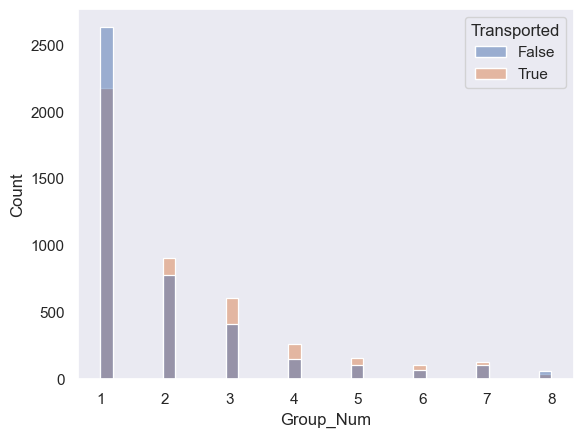

In [184]:
sns.histplot(data=train, x='Group_Num', hue='Transported')

- 혼자 탄 사람이 많다. -> `alone` column
- 1과 8 그리고 나머지가 반대되는 양상이다. -> `end` column

In [185]:
train['alone'] = train['Group_Num'].apply(lambda x: 1 if x==0 else 0)
train['end'] = train['Group_Num'].apply(lambda x: 1 if x in (1, 8) else 0)
test['alone'] = test['Group_Num'].apply(lambda x: 1 if x==0 else 0)
test['end'] = test['Group_Num'].apply(lambda x: 1 if x in (1, 8) else 0)

In [186]:
train.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Age_Category,Total_Amenities,Free,Cabin_deck,Cabin_side,Cabin_num_category,Group,Group_Num,alone,end
0,Europa,False,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,False,2.0,0.0,1,B,P,0.0,0001,1,0,1
1,Earth,False,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,True,1.0,736.0,0,F,S,0.0,0002,1,0,1
2,Europa,False,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,False,2.0,10383.0,0,A,S,0.0,0003,2,0,0
3,Europa,False,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,False,1.0,5176.0,0,A,S,0.0,0003,2,0,0
4,Earth,False,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,True,0.0,1091.0,0,F,S,0.0,0004,1,0,1


- Cabin 은 `Group`(from **PassengerId**)/`HomePlanet` 에 따라 정해질 가능성이 크다고 생각됨 

In [ ]:
GCD_gb=train[train['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=train[train['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=train[train['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((GCD_gb>0).sum(axis=1))
plt.title('#Unique cabin decks per group')

plt.subplot(1,3,2)
sns.countplot((GCN_gb>0).sum(axis=1))
plt.title('#Unique cabin numbers per group')

plt.subplot(1,3,3)
sns.countplot((GCS_gb>0).sum(axis=1))
plt.title('#Unique cabin sides per group')
fig.tight_layout()

#### Transported By Each Column 

In [192]:
# Cabin
## Cabin 의 'deck/num/side' 은 경우의 수가 너무 많기 때문에 deck 으로만 비교한다.
train['Cabin_deck'] = train.Cabin.str.slice(0,1,1)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_deck
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F


In [193]:
# PassengerId - Group
train['Group'] = train.PassengerId.str.slice(0,4)
train['Group_Num'] = train.groupby('Group')['Group'].transform('size')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_deck,Group,Group_Num
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0001,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0002,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0003,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0003,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,0004,1


In [194]:
def transported_by_column(column, ax):
    mean_values = train.groupby(column)['Transported'].mean().sort_values(ascending=False)
    sns.barplot(data=train, x=column, y='Transported', palette="rocket", ax=ax, errorbar=None, order=mean_values.index)
    ax.set_ylim(0.0, 1.0)
    ax.set(xlabel='', ylabel='', title=column)
    for i in ax.containers:
        ax.bar_label(i, padding=8)

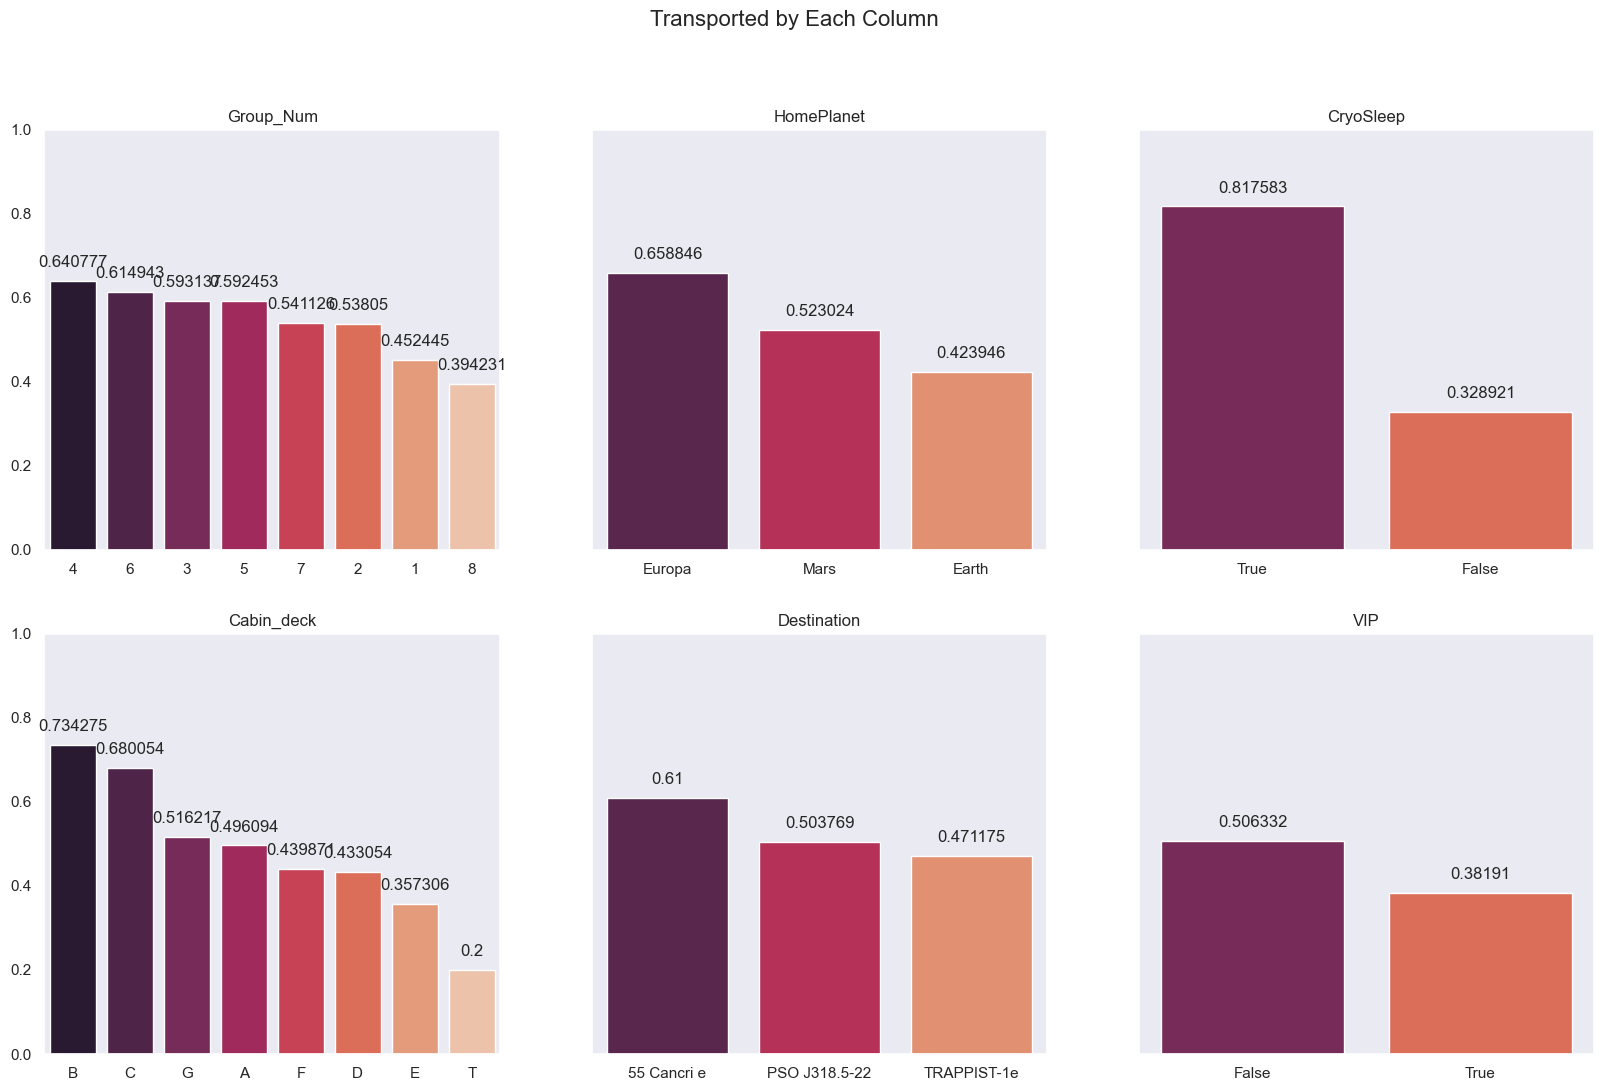

In [197]:
## Only One Column (4. HomePlanet이 다르면, Transported되는 정도가 다른지 체크해보세요)
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True ,figsize=(20, 12))
f.suptitle('Transported by Each Column', fontsize=16)
transported_by_column('Group_Num', ax1)
transported_by_column('HomePlanet', ax2)
transported_by_column('CryoSleep', ax3)
transported_by_column('Cabin_deck', ax4)
transported_by_column('Destination', ax5)
transported_by_column('VIP', ax6)


- `Group_Num`: 그룹 내에 포함된 사람 수에 따른 생존률
    - 너무많거나 적은 수(1, 2, 7, 8) 에 비해
    - 적당히 포함된 수(3, 4, 5, 6) 의 생존률이 더 높은 것을 확인할 수 있다. </br>
    $\rightarrow$ <span style='color: salmon'> (1,2,7,8) 을 **0**, (3,4,5,6) 을  **1** 로 구분한다.</span>

- `Cabin_deck`
    - **deck** 에 따른 연관성을 둘 수 없다.

- 나머지 Column 의 데이터는 전부 ***Transported*** 에 유의미한 영향이 있는 것으로 판단할 수 있다 (drop 할 column 이 없다)
    - 특히 `CryoSleep` 의 여부에 따라 ***Transported*** 가 가장 많이 영향을 받는다. </br>
    $\rightarrow$ <span style='color: salmon'> **CryoSleep**에 대한 추가적인 EDA 를 진행해 본다. </span>

`성능이 너무 안나오면 여기 풀기`

In [199]:
# Create Middel Group Column // 성능이 너무 안나오면 
train['Middle_group'] = train.Group_Num.apply(lambda x: 0 if x in (1,2,7,8) else 1)
train.Middle_group.value_counts()

Middle_group
0    6822
1    1871
Name: count, dtype: int64

In [200]:
# Amenities
# 총 합에 따른 Transported 를 살펴본다.
# 이때, column 에 따른 결측치를 처리하는 것이 아닌 row 에 의해 처리한다.
amenities = train.loc[:, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
row_mean = amenities.mean(axis=1)
for i, row in amenities.iterrows():
    for j, value in enumerate(row):
        if pd.isnull(value):
            amenities.iloc[i, j] = row_mean[i]

In [201]:
train['Total_Amenities'] = amenities.sum(axis=1)
train['Total_Amenities'].describe()

count     8693.000000
mean      1469.698761
std       2860.338611
min          0.000000
25%          0.000000
50%        723.000000
75%       1458.000000
max      35987.000000
Name: Total_Amenities, dtype: float64

c:\Users\hmk40\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


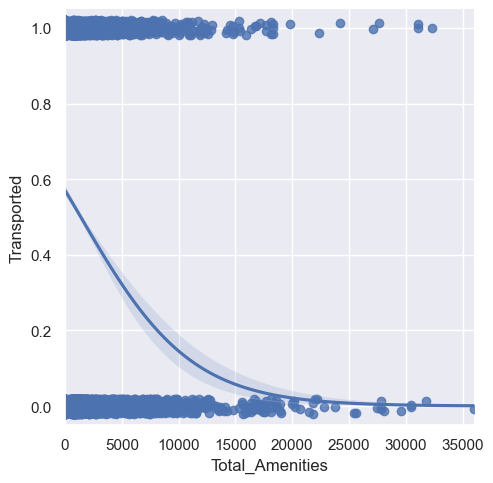

In [202]:
sns.set_theme(style='darkgrid')
ax = sns.lmplot(data=train, x='Total_Amenities', y='Transported', y_jitter=.02, logistic=True)
ax.set(xlim=(0, 36000), ylim=(-.05, 1.05))

`Amenities` 에 지불한 정도(양)에 따른 Transported 에 대한 logistic regression 결과이다.
- 3000 까지는 대략 0.5에서 **Transported** 가 형성된다. 
- 그리고 그 이후로 errorbar 가 생성되기 시작하면서 아래(0)로 향하게 된다. (돌아댕기면 Transported 확률이 적나?)
- 3000 을 기준으로 구분한다 -> `Amenities_Usage`

In [203]:
train['Amenities_Usage'] = train['Total_Amenities'].apply(lambda x: 0 if x < 3000 else 1)
train['Amenities_Usage'].value_counts()

Amenities_Usage
0    7550
1    1143
Name: count, dtype: int64

In [204]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_deck,Group,Group_Num,Middle_group,Total_Amenities,Amenities_Usage
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0001,1,0,0.0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0002,1,0,736.0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0003,2,0,10383.0,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0003,2,0,5176.0,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,0004,1,0,1091.0,0


In [205]:
# Columns 삭제
train = train.drop(columns=['Cabin', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name'])
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Cabin_deck,Group,Group_Num,Middle_group,Total_Amenities,Amenities_Usage
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,False,B,0001,1,0,0.0,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,True,F,0002,1,0,736.0,0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,False,A,0003,2,0,10383.0,1
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,False,A,0003,2,0,5176.0,1
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,True,F,0004,1,0,1091.0,0


In [206]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      8693 non-null   object 
 1   HomePlanet       8492 non-null   object 
 2   CryoSleep        8476 non-null   object 
 3   Destination      8511 non-null   object 
 4   Age              8514 non-null   float64
 5   VIP              8490 non-null   object 
 6   Transported      8693 non-null   bool   
 7   Cabin_deck       8494 non-null   object 
 8   Group            8693 non-null   object 
 9   Group_Num        8693 non-null   int64  
 10  Middle_group     8693 non-null   int64  
 11  Total_Amenities  8693 non-null   float64
 12  Amenities_Usage  8693 non-null   int64  
dtypes: bool(1), float64(2), int64(3), object(7)
memory usage: 823.6+ KB


- HomePlanet, CrypSleep, Destination, Age, VIP, Cabin_deck 채워야함...
    - `HomePlanet`: 1. 같은 그룹(가족일 수 있음), 2. Cabin, 3. Destination
    - `CrypSleep`: 갖혀있으므로 돈못씀 -> **Amenities** 0 이겠지?, 갖혀있는데 VIP인가? -> 자면 거의 VIP 가 아님
    - `Destination`: 1. 같은 그룹(가족일 수 있음), 2. Cabin
    - `VIP`: 1. 자는데 VIP 일 필요 없음. 2. 돈 많이쓰는 사람
    - `Cabin`: 1. 그룹, 2. HomePlanet 3. Destination

##### `CryoSleep & VIP`

<Axes: xlabel='CryoSleep', ylabel='Amenities_Usage'>

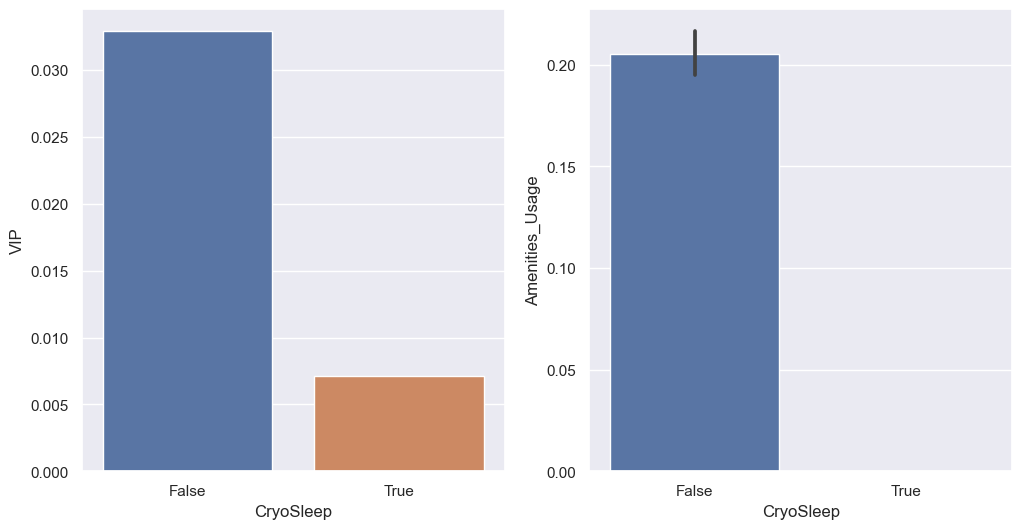

In [207]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6))
sns.barplot(train, x='CryoSleep', y='VIP', errorbar=None, ax=ax1)
sns.barplot(train, x='CryoSleep', y='Amenities_Usage', ax=ax2)

In [209]:
def fill_vip_crypsleep(row):
    if pd.notnull(row['CryoSleep']) and pd.notnull(row['Total_Amenities']):
        return row
    # Amenities  아예 0원
    if pd.isnull(row['CryoSleep']) and row['Total_Amenities'] == 0.0:
        row['CryoSleep'] = True
    # Amenities 거의 사용 안한 사람
    if pd.isnull(row['CryoSleep']) and not row['Amenities_Usage']:
        row['CryoSleep'] = True

    if pd.isnull(row['VIP']):
        row['VIP'] = row['CryoSleep']
    elif pd.isnull(row['CryoSleep']):
        row['CryoSleep'] = row['VIP']
    return row
train = train.apply(fill_vip_crypsleep, axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      8693 non-null   object 
 1   HomePlanet       8492 non-null   object 
 2   CryoSleep        8692 non-null   object 
 3   Destination      8511 non-null   object 
 4   Age              8514 non-null   float64
 5   VIP              8692 non-null   object 
 6   Transported      8693 non-null   bool   
 7   Cabin_deck       8494 non-null   object 
 8   Group            8693 non-null   object 
 9   Group_Num        8693 non-null   int64  
 10  Middle_group     8693 non-null   int64  
 11  Total_Amenities  8693 non-null   float64
 12  Amenities_Usage  8693 non-null   int64  
dtypes: bool(1), float64(2), int64(3), object(7)
memory usage: 823.6+ KB


##### `HomePlanet & Cabin_deck`

In [210]:
def fill_HomePlanet_Cabin_by_Group(row):
    if pd.notnull(row['HomePlanet']) and pd.notnull(row['Cabin_deck']):
        return row

    group = row['Group']
    group_data = train[train['Group'] == group]
    home_mode = group_data['HomePlanet'].mode().values
    deck_mode = group_data['Cabin_deck'].mode().values
    
    if len(home_mode) > 0 and pd.isnull(row['HomePlanet']):
        row['HomePlanet'] = home_mode[0]
    
    if len(deck_mode) > 0 and pd.isnull(row['Cabin_deck']):
        row['Cabin_deck'] = deck_mode[0]

    return row

# apply 함수를 사용하여 결측치를 채움
train = train.apply(fill_HomePlanet_Cabin_by_Group, axis=1)

In [211]:
def fill_HomePlanet_Cabin_by_EachOther(row):
    home_nan = pd.isnull(row['HomePlanet'])
    cabin_nan = pd.isnull(row['Cabin_deck'])

    # HomePlanet과 Cabin_deck 모두 NaN인 경우 해당 행을 반환
    if home_nan and cabin_nan:
        return row

    # HomePlanet이 NaN인 경우
    if home_nan:
        cabin_group = train[train['Cabin_deck'] == row['Cabin_deck']]
        mode_cabin = cabin_group['HomePlanet'].mode().values
        if len(mode_cabin) > 0:
            row['HomePlanet'] = mode_cabin[0]

    # Cabin_deck이 NaN인 경우
    elif cabin_nan:
        home_group = train[train['HomePlanet'] == row['HomePlanet']]
        mode_home = home_group['Cabin_deck'].mode().values
        if len(mode_home) > 0:
            row['Cabin_deck'] = mode_home[0]

    return row

# apply 함수를 사용하여 결측치를 채움
train = train.apply(fill_HomePlanet_Cabin_by_EachOther, axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      8693 non-null   object 
 1   HomePlanet       8689 non-null   object 
 2   CryoSleep        8692 non-null   object 
 3   Destination      8511 non-null   object 
 4   Age              8514 non-null   float64
 5   VIP              8692 non-null   object 
 6   Transported      8693 non-null   bool   
 7   Cabin_deck       8689 non-null   object 
 8   Group            8693 non-null   object 
 9   Group_Num        8693 non-null   int64  
 10  Middle_group     8693 non-null   int64  
 11  Total_Amenities  8693 non-null   float64
 12  Amenities_Usage  8693 non-null   int64  
dtypes: bool(1), float64(2), int64(3), object(7)
memory usage: 823.6+ KB


##### `Destination`

In [212]:
def fill_Destination(row):
    if pd.notnull(row['Destination']):
        return row

    group = row['Cabin_deck']
    group_data = train[train['Cabin_deck'] == group]
    destination_mode = group_data['Destination'].mode().values
    
    if len(destination_mode) > 0 and pd.isnull(row['Destination']):
        row['Destination'] = destination_mode[0]

    return row

train = train.apply(fill_Destination, axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      8693 non-null   object 
 1   HomePlanet       8689 non-null   object 
 2   CryoSleep        8692 non-null   object 
 3   Destination      8693 non-null   object 
 4   Age              8514 non-null   float64
 5   VIP              8692 non-null   object 
 6   Transported      8693 non-null   bool   
 7   Cabin_deck       8689 non-null   object 
 8   Group            8693 non-null   object 
 9   Group_Num        8693 non-null   int64  
 10  Middle_group     8693 non-null   int64  
 11  Total_Amenities  8693 non-null   float64
 12  Amenities_Usage  8693 non-null   int64  
dtypes: bool(1), float64(2), int64(3), object(7)
memory usage: 823.6+ KB


In [225]:
# 안채워진건 이제는 버리고, 학습에 사용하지 않을 column 삭제
train = train.drop(columns=['PassengerId', 'Total_Amenities', 'Group_Num', 'Group', 'Age'])
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8688 entries, 0 to 8692
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   HomePlanet       8688 non-null   object
 1   CryoSleep        8688 non-null   object
 2   Destination      8688 non-null   object
 3   VIP              8688 non-null   object
 4   Transported      8688 non-null   bool  
 5   Cabin_deck       8688 non-null   object
 6   Middle_group     8688 non-null   int64 
 7   Amenities_Usage  8688 non-null   int64 
dtypes: bool(1), int64(2), object(5)
memory usage: 551.5+ KB


이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [226]:
train.head()

,HomePlanet,CryoSleep,Destination,VIP,Transported,Cabin_deck,Middle_group,Amenities_Usage
0,Europa,False,TRAPPIST-1e,False,False,B,0,0
1,Earth,False,TRAPPIST-1e,False,True,F,0,0
2,Europa,False,TRAPPIST-1e,True,False,A,0,1
3,Europa,False,TRAPPIST-1e,False,False,A,0,1
4,Earth,False,TRAPPIST-1e,False,True,F,0,0


In [227]:
## One-Hot encoding
train_OHE = pd.get_dummies(data=train, columns=["HomePlanet", "Destination", "Cabin_deck"])


In [232]:
train_OHE.CryoSleep = train_OHE.CryoSleep.apply(lambda x: False if x == 'False' else True)
train_OHE.VIP = train_OHE.VIP.apply(lambda x: False if x == 'False' else True)
train_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8688 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   CryoSleep                  8688 non-null   bool 
 1   VIP                        8688 non-null   bool 
 2   Transported                8688 non-null   bool 
 3   Middle_group               8688 non-null   int64
 4   Amenities_Usage            8688 non-null   int64
 5   HomePlanet_Earth           8688 non-null   bool 
 6   HomePlanet_Europa          8688 non-null   bool 
 7   HomePlanet_Mars            8688 non-null   bool 
 8   Destination_55 Cancri e    8688 non-null   bool 
 9   Destination_PSO J318.5-22  8688 non-null   bool 
 10  Destination_TRAPPIST-1e    8688 non-null   bool 
 11  Cabin_deck_A               8688 non-null   bool 
 12  Cabin_deck_B               8688 non-null   bool 
 13  Cabin_deck_C               8688 non-null   bool 
 14  Cabin_deck_D               86

In [233]:
train_OHE.head(3)

,CryoSleep,VIP,Transported,Middle_group,Amenities_Usage,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T
0,True,True,False,0,0,False,True,False,False,False,True,False,True,False,False,False,False,False,False
1,True,True,True,0,0,True,False,False,False,False,True,False,False,False,False,False,True,False,False
2,True,True,False,0,1,False,True,False,False,False,True,True,False,False,False,False,False,False,False


### 4. 학습 데이터 분할

In [236]:
#### 아래 train / validation을 고정해주세요!! ####

X = train_OHE.drop(columns='Transported') # feature vector
y = train_OHE.Transported                 # target value

# 트테트테
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(6950, 18) (6950,) (1738, 18) (1738,)


### 5. 학습 및 평가

In [241]:
### 9. XGBClassifier를 학습해보세요. hyper-parameter는 자유롭게 넣어주세요.
model = XGBClassifier(
    max_depth = 10,
    reg_lambda = 3,
    tree_method = 'exact',
    n_estimators = 100,
    learning_rate = 0.1,
    colsample_bynode = 0.8,
    random_state = 42,
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.8,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [242]:
print("Prediction")
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

train_score = accuracy_score(y_train, pred_train)
val_score = accuracy_score(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)

Prediction
Train Score : 0.6799
Validation Score : 0.6680


- Amenity를 다 더해서 나누는 건 좀 그럣나

### 6. Hyper-parameter Tuning

 - 이 링크를 참고하세요. https://xgboost.readthedocs.io/en/stable/parameter.html

 - 이 링크도 참고하세요. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
from sklearn.model_selection import GridSearchCV

### 10. GridSearchCV 함수를 공부해서, 아래 param_grid를 채워넣고 검증 성능이 높은 hyper-parameter 조합을 찾아보세요.

param_grid = {
    'n_estimators' : [],
    'max_depth' : [],
    'colsample_bynode' : [],
    'learning_rate' : [],
    'reg_lambda' : [],
    'random_state' : [42]
} # 3 x 2 x 2 x 2 x 2 = 48개.

gcv = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

In [ ]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_val = gcv.predict(X_val)

gcv_train_score = accuracy_score(y_train, gcv_pred_train)
gcv_val_score = accuracy_score(y_val, gcv_pred_val)

print("Train ACC Score : %.4f" % gcv_train_score)
print("Validation ACC Score : %.4f" % gcv_val_score)